## Gender Labelling with Python

### Import libraries
For code readability the most of the implementation is extracted as functions in file _genderclassifierfunctions.py_


In [1]:
from genderclassifierfunctions import unzipfile
from genderclassifierfunctions import loadjsonfiletolist
from genderclassifierfunctions import writecsvfile
from genderclassifierfunctions import clean
from genderclassifierfunctions import feature_processing
from genderclassifierfunctions import feature_selection_classifier_1
from genderclassifierfunctions import feature_selection_classifier_2
from genderclassifierfunctions import feature_selection_classifier_3
from genderclassifierfunctions import kmeans_classification
from genderclassifierfunctions import minibatchkmeans_classifier
from genderclassifierfunctions import plot3d
from genderclassifierfunctions import plot2d
from genderclassifierfunctions import eigen_decomposition
from genderclassifierfunctions import concatenate_result
import genderclassifierfunctions
from sklearn.decomposition import PCA

### Unzip the file
Unzip the file <i>test\_data.zip</i> in the current directory with password calculated(SHA-256 hash) from the passcode 'welcometotheiconic'.
Json file _data.json_ will be extracted to the current directory


In [2]:
unzipfile('test_data.zip','welcometotheiconic')

### Load json file as python list and pre-processing
For code readability it would be better to put all data cleaning tasks in cleaning step, however for performance/convenience  following pre-processing/cleaning tasks are also executed.
-  Removed 249 duplicated records by checking key <i>customer\_id</i>
-  Field <i>coupon_discount_applied</i> is missing for some records, set 0 if missing
-  Field <i>is\_newsletter\_subscriber</i> has string value Y/N, convert to 1/0 for processing


In [3]:
keys, datalist = loadjsonfiletolist('data.json')

Duplication: 249


### Clean the data

#### Following corrections are made to the data
-  <i>days\_since\_last\_order</i> is in unit of hours, divide it by 24 to get the correctvalue
-  <i>average\_discoun\t_used</i> is multipliedby 1000, divideby 1000 to get the correctvalue
-  Removed 249 duplicated records by checking key <i>customer\_id</i>
-  Field <i>coupon_discount_applied</i> is missing for some records causing data not aligned, set 0 if missing to fix the issue
-  Field <i>is\_newsletter\_subscriber</i> has string value Y/N, converted to 1/0 for further processing
-  _returns_ is rutruned items not returnd orders

#### Found following issues/finding in data but no correction is made because not necessary or lack of information

-  items in subcategories like wapp_items, wspt_items etc don't add up to the total items, which means some discrepancy in data 
-  <i>different\_addresses</i> is a boolean value Ture/False, it probably shows if billing and shipping address are different, it doesn't match the discription in github "Number of times a different billing and shipping address was used" https://github.com/theiconic/datascientist 
-  Same boolean vs integer issue can be found with value <i>cc\_payments, paypal\_payments, afterpay\_payments, apple\_payments</i> note boolean features are normally not used by k-means clustering
-  Extra columns <i>redpen\_discount\_used, coupon\_discount\_applied<i> are available
-  Few customers apprently were buying for resale, their buying pattern may be different


In [4]:
dataarray = clean(datalist)

 ### Extract and prepare all the needed features
 - Also normalize each feature because K means is sensitive to variance in data
 - Categorical values are skipped because K means doesn't work well with them due to only 2 values 0/1
 - Absolute values are not used, they are more related with how long the customer is with ICONIC and less related with
    gender, hence they may do more harm than good
 - I believe Curvy item has a strong correlation with gender, however they are very right-skewed use np.power(1/6) to
    smooth it
 Full list of selected features as following
 
|Index|Item|
|---|---|
|	0	|	items/ orders	|
|	1	|	cancels / orders	|
|	2	|	returns / items	|
|	3	|	voucher / orders	|
|	4	|	female_items / items	|
|	5	|	male_items / items	|
|	6	|	unisex_items / items	|
|	7	|	wapp_items / items	|
|	8	|	wftw_items / items	|
|	9	|	mapp_items / items	|
|	10	|	wacc_items / items	|
|	11	|	macc_items / items	|
|	12	|	mftw_items / items	|
|	13	|	wspt_items / items	|
|	14	|	mspt_items / items	|
|	15	|	curvy_items / items (smoothed)	|
|	16	|	sacc_items / items	|
|	17	|	msite_orders / orders	|
|	18	|	desktop_orders / orders	|
|	19	|	android_orders / orders	|
|	20	|	ios_orders / orders	|
|	21	|	other_device_orders / orders	|
|	22	|	work_orders / orders	|
|	23	|	home_orders / orders	|
|	24	|	parcelpoint_orders / orders	|
|	25	|	other_collection_orders / orders	|
|	26	|	average_discount_onoffer / orders	|
|	27	|	average_discount_used / orders	|
|	28	|	revenue / order	|


In [5]:
allfeatures = feature_processing(dataarray)

### The Ensemble Learning Model with K-means base
For this problem I choose an Ensemble Learning approach:
-  3 different models are used to do the clustering and combiend to give the final result. (i.e. final label needs to get at least 2 votes from 3 classifiers)
-  Model 1: K-means with gender related features
-  Model 2: K-means with gender related features and cost effective items like discount rate, cancel/order
-  Model 3: Mini Batch K-means with gender related features plus payment method and shipment related features

### Model 1: K-means

#### The K means classifier
-  Clustering assign random labels to female (0 or 1), the prior knowledge tells us males < half of the samples, I use the knowledge to assign 0 to female, 1 to male

#### The features 
-  I selected gender and discountrelated features from all features as base, because we have the prior knowledge that these are good indicators
-  By eigen decomposition I can see a few features either has too much unintended contribution or negative contribution. They are removed. e.g. parcel shipment features being the biggest contributor or male items not contribute to male gender labeling
-  Following are the features

|Index|Item|
|---|---||
|	0	|	female_items / items||
|	1	|	male_items / items|
|	2	|	wapp_items / items|
|	3	|	wftw_items / items|
|	4	|	mapp_items / items|
|	5	|	wacc_items / items|
|	6	|	macc_items / items|
|	7	|	mftw_items / items|
|	8	|	average_discount_onoffer / orders|
|	9	|	average_discount_used / orders|

In [6]:
featureClassifier1 = feature_selection_classifier_1(allfeatures)
result_1_kmeans = kmeans_classification(2, featureClassifier1)

First 30 result, female = 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0


### Model 2: K-means

#### The K means classifier
-  Clustering assign random labels to female (0 or 1), the prior knowledge tells us males < half of the samples, I use the knowledge to assign 0 to female, 1 to male

#### The features 
-  I selected gender related features plus cost effective items like discount rate, cancel/order from all features
-  By eigen decomposition I can see a few features either has too much unintended contribution or negative contribution. They are removed. e.g. parcel shipment features being the biggest contributor or male items not contribute to male gender labeling
-  Following are the features

|Index|Item|
|---|---|
|	0	|	items/ orders	|
|	1	|	cancels / orders	|
|	2	|	returns / items	|
|	3	|	voucher / orders	|
|	4	|	female_items / items	|
|	5	|	male_items / items	|
|	6	|	wapp_items / items	|
|	7	|	wftw_items / items	|
|	8	|	mapp_items / items	|
|	9	|	wacc_items / items	|
|	10	|	macc_items / items	|
|	11	|	mftw_items / items	|
|	12	|	mspt_items / items	|
|	13	|	curvy_items / items	|
|	14	|	average_discount_onoffer / orders	|
|	15	|	average_discount_used / orders	|
|	16	|	revenue / order	|


In [7]:
featureClassifier2 = feature_selection_classifier_2(allfeatures)
result_2_kmeans = kmeans_classification(2, featureClassifier2)

First 30 result, female = 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0


### Model 3: Mini Batch K-means

#### The Mini Batch K means classifier
-  Mini Batch K-means has been proposed as an alternative to the K-means algorithm for clustering massive datasets. The advantage of this algorithm is to reduce the computational cost by not using all the dataset each iteration but a subsample of a fixed size

#### The features 
-  I selected gender and discount related features plus payment method and shipment related features from all features
-  By eigen decomposition I can see a few features either has too much unintended contribution or negative contribution. They are removed. e.g. parcel shipment features being the biggest contributor or male items not contribute to male gender labeling
-  Following are the features

|Index|Item|
|---|---|
|	Index	|	Item	|
|	0	|	female_items / items	|
|	1	|	male_items / items	|
|	2	|	wapp_items / items	|
|	3	|	wftw_items / items	|
|	4	|	mapp_items / items	|
|	5	|	wacc_items / items	|
|	6	|	macc_items / items	|
|	7	|	mftw_items / items	|
|	8	|	curvy_items / items	|
|	9	|	msite_orders / orders	|
|	10	|	desktop_orders / orders	|
|	11	|	android_orders / orders	|
|	12	|	ios_orders / orders	|
|	13	|	other_device_orders / orders	|
|	14	|	home_orders / orders	|
|	15	|	other_collection_orders / orders	|
|	16	|	average_discount_onoffer / orders|
|	17	|	average_discount_used / orders|


In [8]:
featureClassifier3 = feature_selection_classifier_3(allfeatures)
pcaResult = PCA(n_components=5).fit(featureClassifier3).transform(featureClassifier3)
result_3_mbk = minibatchkmeans_classifier(2, featureClassifier3)

First 30 results, female = 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0


### Final Model: Unsupervised ensemble learning
-  Final label needs to get at least 2 votes from 3 classifiers (female = 0, male = 1)

In [11]:
final_result = (result_1_kmeans + result_1_kmeans + result_3_mbk)
final_result = [1 if row > 1 else 0 for row in final_result]
print("First 30 final results female = 0")
print(*final_result[:30])

First 30 final results female = 0
0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0


### Print result to csv file _GenderLabelingFinal.csv_ for easy evaluation

In [12]:
resultkeys, resultdata = concatenate_result( keys,  datalist,  "gender(female=0)", final_result)
writecsvfile('.\GenderLabelingFinal.csv', resultkeys, resultdata)

Display first 5 classification result: customer_id, gender(femal=0)
64f7d7dd7a59bba7168cc9c960a5c60e 0
fa7c64efd5c037ff2abcce571f9c1712 0
18923c9361f27583d2320951435e4888 0
aa21f31def4edbdcead818afcdfc4d32 1
668c6aac52ff54d4828ad379cdb38e7d 0


### Plot final result in 2D with first 2 components of PCA

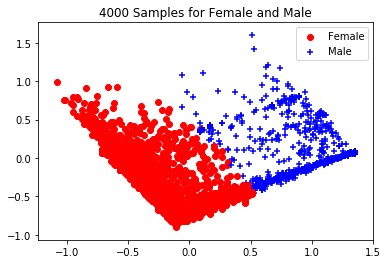

In [13]:
plot2d(pcaResult, final_result, 0, 1)

### A bit fancier,  plot final result in 3D with first 3 components of PCA

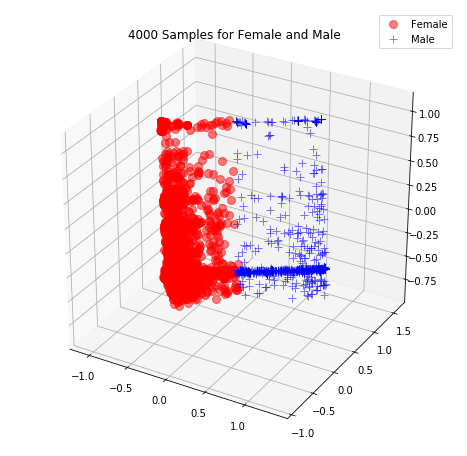

In [14]:
plot3d(pcaResult, final_result, 0, 1, 2)

### Result Analysis: Feature contribution:

I use eigendecomposition to find which features contribute most to the clustering result, which helped to select the features and understand the result

eigen value decomposition
    $$ A \overrightarrow{v} = \lambda \overrightarrow{v} $$
The eigenvectors $ \overrightarrow{v} $ shows how much each feature contribute(weight) to the linear transformation. Since eigenvalue $ \lambda $ are sorted, we can see the weight of each feature's impact in the descending order

Following diagram shows the first and second components of PCA of features of classifier 1, we can see the feature 1: female_items / items contribute positivly to first component and feature 7 mftw_items / items contributs negatively.

Other features like average_discount_onoffer/orders or payment/shipment related features also contributes to the final result expecially when gender related features provide neutral information

By manually checking the result, I noticed around 100 to 200 lables may be incorrect, for example about 6 customers bought Curvy items which suggested they might be femals but the classification shows otherwise.

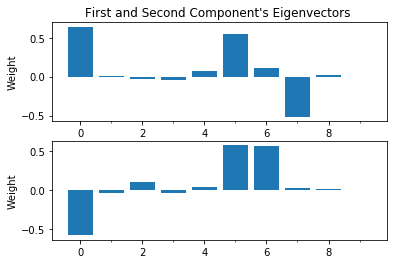

In [15]:

eigen_decomposition(featureClassifier1, range(featureClassifier1.shape[1]))

### Recommendation of extra features
1. Colour of items (expecially for unisex items)
2. Size of items
3. Customer's name/nick name/email address
4. Brand of items
5. Search history


### Appendix: Python Documentation
For the detailed documentation of all functions in file _genderclassifierfunctions.py_ please run

In [16]:

help(genderclassifierfunctions)

Help on module genderclassifierfunctions:

NAME
    genderclassifierfunctions

FUNCTIONS
    agglomerative_clustering(nu_clusters, data2d)
        The agglomerative_clustering classifier, the code is provided but not used
        Clustering assign random labels to female (0 or 1), the prior knowledge tells us males < half of the samples
        we use the knowledge to assign 0 to female, 1 to male
        :param nb_clusters: number of clusters(gender), 2
        :param data2d: data to be classified
        :return: labeled data
    
    clean(listoflist)
        Following corrections are made to the data
            days_since_last_order is in unit of hours, divide it by 24 to get the correctvalue
            average_discoun _used is multipliedby 1000, divideby 1000 to get the correctvalue
            Removed 249 duplicated records by checking key customer_id
            Field coupon_discount_applied is missing for some records causing data not aligned, set 0 if missing to fix the issu